# Gap opening figure

In [1]:
%load_ext autoreload
%autoreload 2
%run ~/FKMC/notebooks/notebook_preamble.py
%matplotlib inline
%run ./matplotlib_fig_settings.py
np.seterr(under = 'ignore')
from time import time
from munch import munchify

Imported pathlib::Path, os, munch::Munch, pickle, logging, itertools::count, matplotlib::colors
Names are pyplot = plt, matplotlib = mpl, numpy = np


In [2]:
import numpy as np
from time import time
from operator import mul
from functools import reduce
from itertools import count
from munch import Munch
from itertools import zip_longest
import logging
import multiprocessing as mp

import re
from pathlib import Path

import scipy
from FKMC.general import index_histogram_array, sort_IPRs, smooth, shapes, normalise_IPR
from FKMC.import_funcs import shape_hints, timefmt

from FKMC.import_funcs import  mean_over_MCMC, IPRandDOS, extract, get_data_funcmap_chain_ext, extractStates
from FKMC.import_funcs import incremental_get_data_funcmap_chain_ext, incremental_load

In [3]:
from scipy.stats import sem
from FKMC.plotting import spread
from FKMC.general import scaling_dimension
import multiprocessing as mp

def interpolate_IPR(E_bins, unsmoothed_DOS, IPR, dIPR):
    newshape = (IPR.size // IPR.shape[-1], IPR.shape[-1])
    _DOS = unsmoothed_DOS.reshape(newshape)
    _IPR = IPR.reshape(newshape)
    _dIPR = dIPR.reshape(newshape)
    
    for i, DOS, I, dI in zip(count(), _DOS, _IPR, _dIPR):
        ei = DOS > 0
        if any(ei):
            _I = I[ei]
            _dI = dI[ei]
            xI = E_bins[1:][ei]

            _IPR[i] = np.interp(E_bins[1:], xI, _I)
            _dIPR[i] = np.interp(E_bins[1:], xI, _dI)
        else:
            _IPR[i] = E_bins[1:] * np.NaN
            _dIPR[i] = E_bins[1:] * np.NaN

def fit_errors(X, Y, dY):
    try:
        (m, c), cov = np.ma.polyfit(X, Y, deg = 1, cov=True, w = 1 / dY)
        dm, dc = np.sqrt(np.diag(cov))
        return m, c, dm, dc
    except np.linalg.LinAlgError:
        return np.NaN, np.NaN, np.NaN, np.NaN

def fit_no_errors(X, Y):
    try:
        (m, c), cov = np.ma.polyfit(X, Y, deg = 1, cov=True)
        dm, dc = np.sqrt(np.diag(cov))
        return m, c, dm, dc
    except np.linalg.LinAlgError:
        return np.NaN, np.NaN, np.NaN, np.NaN

def scaling_dimension_multidim(Ns, IPR, dIPR, use_true_errors = True):
    original_shape = IPR.shape
    newshape = (IPR.shape[0], IPR.size // IPR.shape[0])
    finalshape = IPR.shape[1:]
    IPR = IPR.reshape(newshape)
    dIPR = dIPR.reshape(newshape)
    print(original_shape, newshape, finalshape)
    
    Y = np.log(IPR).T
    dY = dIPR.T / IPR.T #take the maximum error across the energy spectrum because we can't do it individually
    #set a minimum 5% error
    dY = np.maximum(dY, 5/100)
    X = np.broadcast_to(np.log(Ns), Y.shape)
    
    with mp.Pool(16) as pool:
        if use_true_errors:
            args = np.stack([X, Y, dY], axis = 1)
            fit = fit_errors
        else:
            args = np.stack([X, Y, dY], axis = 1)
            fit = fit_no_errors
        
        print(args.shape)
        m, c, dm, dc = np.array(pool.starmap(fit, args, chunksize = 1000)).T

    return m.reshape(finalshape), c.reshape(finalshape), dm.reshape(finalshape), dc.reshape(finalshape)

from FKMC.general import scaling_dimension

def interpolate_and_smooth(o):
    interpolate_IPR(o.E_bins, unsmoothed_DOS=o.DOS, IPR=o.IPR, dIPR=o.dIPR)

    o.dIPR = sem(o.IPR, axis = 1)
    o.IPR = np.mean(o.IPR, axis = 1)
    o.dDOS = sem(o.DOS, axis = 1)
    o.DOS = np.mean(o.DOS, axis = 1)

    o.IPR = smooth(o.IPR, scale = 0.5, axis = -1)
    o.dIPR = smooth(o.dIPR, scale = 0.5, axis = -1)
    o.DOS = smooth(o.DOS, scale = 0.5, axis = -1)

    try:
        o.m, o.c, o.dm, o.dc = scaling_dimension(o.Ns, o.IPR, o.dIPR, use_true_errors = True)
    except:
        print('Scaling dimension fit failed on at least one value, falling back to loop')
        o.m, o.c, o.dm, o.dc = scaling_dimension_multidim(o.Ns, o.IPR, o.dIPR, use_true_errors = True)
    
    return o

In [10]:
%%time
functions = [
    mean_over_MCMC('Mf_moments', N_error_bins = 10),
    IPRandDOS(),
    extractStates(),
]
o1 = incremental_load(folder = '~/HPC_data/gap_open_U=2', functions = functions, force_reload = True)
print(o1.Ts)

functions = [
    mean_over_MCMC('Mf_moments', N_error_bins = 10),
    IPRandDOS(),
]
o2 = incremental_load(folder = '~/HPC_data/gap_opening_U=2_low_temp', functions = functions, force_reload = False)

if len(o1.IPR.shape) == 4:
    assert(all(o1.Ts[:10] ==  o2.Ts)) #assert that 02 just fills in the lower T data of o1
    for name in ['IPR', 'DOS']:
        o1[name][:, :, :10, :] = o2[name]
        
del o2

o1 = interpolate_and_smooth(o1)

with open('/home/tch14/HPC_data/pickled_data/gap_opening.pickle', 'wb') as file:
    pickle.dump(o1, file)
print(o1.keys())

INFO:FKMC.import_funcs:looking in /rds/general/user/tch14/home/HPC_data/gap_open_U=2
DEBUG:FKMC.import_funcs:structure_names = ['Rs', 'Ts']
DEBUG:FKMC.import_funcs:structure_dims = (5, 50)
DEBUG:FKMC.import_funcs:Missing jobs, should all be up to 4
DEBUG:FKMC.import_funcs:task_id: chain_ids
DEBUG:FKMC.import_funcs:48: {0, 1}
DEBUG:FKMC.import_funcs:49: {0, 1, 2}
DEBUG:FKMC.import_funcs:142: {0}
DEBUG:FKMC.import_funcs:141: {0}
INFO:FKMC.import_funcs:Expected number of tasks 250
INFO:FKMC.import_funcs:Measured number of tasks 250
INFO:FKMC.import_funcs:Expected number of chains None
INFO:FKMC.import_funcs:Shortest Chain 1
INFO:FKMC.import_funcs:Longest Chain 5
INFO:FKMC.import_funcs:Using chain length 5
INFO:FKMC.import_funcs:Logger keys: ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subcl

[PosixPath('/rds/general/user/tch14/home/HPC_data/gap_open_U=2/code/gap_opening.py')]
Ham_params:  t=1, alpha=1.25, mu=0, beta=varying, J=5, U=2, normalise=True,


Tasks per chain: 5,

Each doing 5000 steps,

25000 total chain length,

2500 samples,


MCMC_params:  N_steps=5000, N_burn_in=5000, thin=10, proposal=<function p_multi_site_uniform_reflect at 0x2b2bad0f7290>, accept_function=<function perturbation_accept at 0x2b2bad0f7560>, warnings=False,


DEBUG:FKMC.import_funcs:observables.flat['IPRs'] = np.array(shape = (3, 250, 2000), dtype = <class 'numpy.float64'>) approx size: 0.01Gb
DEBUG:FKMC.import_funcs:observables.flat['DOS'] = np.array(shape = (3, 250, 2000), dtype = <class 'numpy.float64'>) approx size: 0.01Gb
DEBUG:FKMC.import_funcs:observables.flat['state'] = [np.array(shape = (N_jobs, observables.max_MC_step, N), dtype = float64)] approx size: 0.01Gb
DEBUG:FKMC.import_funcs:observables.flat['time'] = np.array(shape = (3, 250), dtype = float64) approx size: 0.00Gb
DEBUG:FKMC.import_funcs:observables.flat['accept_rates'] = np.array(shape = (3, 250), dtype = float64) approx size: 0.00Gb
DEBUG:FKMC.import_funcs:observables.flat['proposal_rates'] = np.array(shape = (3, 250), dtype = float64) approx size: 0.00Gb
DEBUG:FKMC.import_funcs:todo: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 4

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 

DEBUG:FKMC.import_funcs:/rds/general/user/tch14/home/HPC_data/gap_open_U=2/data/48_2.npz is expected but missing!
DEBUG:FKMC.import_funcs:/rds/general/user/tch14/home/HPC_data/gap_open_U=2/data/48_3.npz is expected but missing!
DEBUG:FKMC.import_funcs:/rds/general/user/tch14/home/HPC_data/gap_open_U=2/data/48_4.npz is expected but missing!


47 48 

NameError: name 'Valueerror' is not defined

In [5]:
%%time
functions = [
    mean_over_MCMC('Mf_moments', N_error_bins = 10),
    IPRandDOS(),
]
olog = incremental_load(folder = '~/HPC_data/gap_opening_logarithmic', functions = functions, force_reload = False)

olog = interpolate_and_smooth(olog)

with open('/home/tch14/HPC_data/pickled_data/gap_opening_high_temp_log.pickle', 'wb') as file:
    pickle.dump(olog, file)

INFO:FKMC.import_funcs:A whole new chain since last time! regenerate the entire thing because new space needs to be allocated


Scaling dimension fit failed on at least one value, falling back to loop
(3, 7, 2000) (3, 14000) (7, 2000)
(14000, 3, 3)
CPU times: user 730 ms, sys: 421 ms, total: 1.15 s
Wall time: 21.7 s


In [4]:
%%time
functions = [mean_over_MCMC('Mf_moments', N_error_bins = 10), IPRandDOS(), extractStates(),]
oU5 = incremental_load(folder = '~/HPC_data/gap_opening_U=5', functions = functions, force_reload = False)
oU5 = interpolate_and_smooth(oU5)

functions = [mean_over_MCMC('Mf_moments', N_error_bins = 10), IPRandDOS(),]
oU5log = incremental_load(folder = '~/HPC_data/gap_opening_U-5_logarithmic', functions = functions, force_reload = True)
oU5log = interpolate_and_smooth(oU5log)

with open('/home/tch14/HPC_data/pickled_data/gap_opening_U=5.pickle', 'wb') as file:
    pickle.dump(oU5, file)
    
with open('/home/tch14/HPC_data/pickled_data/gap_opening_U=5_log.pickle', 'wb') as file:
    pickle.dump(oU5log, file)

INFO:FKMC.import_funcs:A whole new chain since last time! regenerate the entire thing because new space needs to be allocated


Scaling dimension fit failed on at least one value, falling back to loop
(3, 50, 2000) (3, 100000) (50, 2000)
(100000, 3, 3)


INFO:FKMC.import_funcs:looking in /rds/general/user/tch14/home/HPC_data/gap_opening_U-5_logarithmic
DEBUG:FKMC.import_funcs:structure_names = ['Rs', 'Ts']
DEBUG:FKMC.import_funcs:structure_dims = (5, 7)


[PosixPath('/rds/general/user/tch14/home/HPC_data/gap_opening_U-5_logarithmic/code/gap_opening_U-5_logarithmic.py')]
Ham_params:  t=1, alpha=1.25, mu=0, beta=varying, J=5, U=5, normalise=True,


Tasks per chain: 5,

Each doing 500 steps,

2500 total chain length,

250 samples,


MCMC_params:  N_steps=500, N_burn_in=500, thin=10, proposal=<function p_multi_site_uniform_reflect at 0x2ad060a9d3b0>, accept_function=<function perturbation_accept at 0x2ad060a9d680>, warnings=False,


DEBUG:FKMC.import_funcs:Missing jobs, should all be up to 4
DEBUG:FKMC.import_funcs:task_id: chain_ids
INFO:FKMC.import_funcs:Expected number of tasks 35
INFO:FKMC.import_funcs:Measured number of tasks 35
INFO:FKMC.import_funcs:Expected number of chains None
INFO:FKMC.import_funcs:Shortest Chain 5
INFO:FKMC.import_funcs:Longest Chain 5
INFO:FKMC.import_funcs:Using chain length 5
INFO:FKMC.import_funcs:Logger keys: ['A', 'Fc', 'Ff', 'IPRs', 'Mf_moments', 'N_cumulants', 'N_sites', 'N_steps', 'Nc', 'Nf', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'accept_rates', 'classical_accept_rates', 'eigenval_bins', 'eigenvals', 'last_state', 'powers', 'proposal_rates', 'return_vals', 'st

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 

INFO:FKMC.import_funcs:########################################################################

INFO:FKMC.import_funcs:Observables has keys: dict_keys(['functions', 'flat', 'hints', 'processed_task_ids', 'this_run', 'datapath', 'codepath', 'py_script', 'batch_params', 'structure_names', 'structure_dims', 'N_tasks', 'chains', 'N_chains', 'original_N_steps', 'thin', 'N_steps', 'max_MC_step', 'E_bins', 'Ns', 'parameters', 'MCMC_params', 'structure_dimensions', 'chain_id', 'task_id', 'allow_pickle', 'desc', 'Rs', 'Ts', 'Mf_moments', 'DOS', 'IPR', 'dDOS', 'dIPR', 'time', 'accept_rates', 'proposal_rates'])
INFO:FKMC.import_funcs:    Completed jobs:?
    MCMC Steps: 5 chains of 500 for 2500 with thinning = 10 for 250 recorded steps
    Burn in: 500
    Structure_names: {'Rs': 5, 'Ts': 7}
    Ns = [ 60. 120. 270.]
    Runtimes: 
        Average: 6.0 hours
        Min: 2.0 hours
        Max: 9.0 hours
        Total: 1.0 weeks
    


34 Scaling dimension fit failed on at least one value, falling back to loop
(3, 7, 2000) (3, 14000) (7, 2000)
(14000, 3, 3)
CPU times: user 20.2 s, sys: 3.38 s, total: 23.6 s
Wall time: 22 s


In [ ]:
from itertools import count
o = oU5
    
N = 3
T_is = np.arange(len(o.Ts))[:10]

f, rows = plt.subplots(len(T_is),3, sharex = 'all', 
                       #sharey = 'col',
                       figsize = (8, 1*len(T_is)), gridspec_kw = dict(hspace = 0, wspace = 0))

for T_i, axes in zip(T_is, rows):
    
    axes[0].set(ylabel = f'T = {o.Ts[T_i]:2g}')
    
    axes[1].tick_params(labelleft = False)
    axes[2].tick_params(labelleft = False)

    for i,N in enumerate(o.Ns): 
        spread(axes[0], o.E_bins[1:], o.DOS[i, T_i], o.dDOS[i, T_i], label = f'N = {N}')

    lines = [None for _ in o.Ns]
    for i,N in enumerate(o.Ns): 
        lines[i] = spread(axes[1], o.E_bins[1:], 
                          np.where( o.DOS[i, T_i] > 0.1, o.IPR[i, T_i], np.NaN),
                          o.dIPR[i, T_i],
                          label = f'N = {N}')
    if 'm' in o:
        spread(axes[2], o.E_bins[1:], 
                          np.where( o.DOS[-1, T_i] > 0.1, -o.m[T_i], np.NaN),
                          o.dm[T_i],
                          label = f'N = {N}')

    axes[0].set(xlim = (0,3))
    axes[2].set(ylim = (0,1))
    
f.legend(lines, labels = [f'N = {N}' for N in o.Ns])

o.Ns = [ 60. 120. 270.]
N1 = 270.0, N2 = 60.0


/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


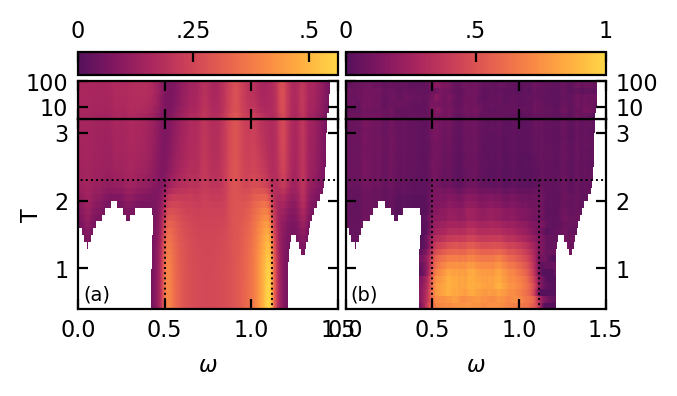

In [8]:
%run ./matplotlib_fig_settings.py

def plot_gap_opening(o, olog = None, xlim = (-3.5/2, 3.5/2)):
    from FKMC.general import smooth
    import matplotlib.gridspec as gridspec

    f = plt.figure()
    gs0 = gridspec.GridSpec(2, 2, figure=f, wspace = 0.03,
                                            hspace = 0.05,
                                            height_ratios = (1,10),
                                            width_ratios = (1,1))

    lgs, rgs = [gs0[1, i].subgridspec(2,1, 
                                      height_ratios = (1,5),
                                      hspace = 0,
                                     ) for i in range(2)]
    axes = [f.add_subplot(lgs[1,0]), f.add_subplot(rgs[1,0])]
    logaxes = [f.add_subplot(lgs[0,0]), f.add_subplot(rgs[0,0])]
    caxes = [f.add_subplot(gs0[0,0]), f.add_subplot(gs0[0,1])]

    ax = axes[0]
    logax = logaxes[0]


    print(f'o.Ns = {o.Ns}')
    i1 = 2; i2 = 0
    N1 = o.Ns[i1]; N2 = o.Ns[i2]
    print(f'N1 = {N1}, N2 = {N2}')


    E_i = 2
    E_threshold = 0.07
    E = smooth(o.DOS[E_i], scale = 0.5, axis = -1)
    E = np.where(E > 0.06, E, np.NaN)
    I = np.where(E > 0.06, -o.m, np.NaN)

    if olog:
        olog.E = smooth(olog.DOS[E_i], scale = 0.5, axis = -1)
        olog.E = np.where(olog.E > 0.06, olog.E, np.NaN)
        olog.I = np.where(olog.E > 0.06, -olog.m, np.NaN)

    norm = mpl.colors.Normalize(vmin = 0)
    custom_cmap.set_bad(color='white')
    pcol = ax.pcolormesh(o.E_bins/o.parameters.U, o.Ts, E, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True)
    cbar = f.colorbar(pcol, cax = caxes[0], orientation="horizontal")

    if olog: pcol = logax.pcolormesh(o.E_bins/o.parameters.U, olog.Ts, olog.E, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True)

    ax.set(ylabel = 'T', xlabel = '$\omega$', ylim = (0.1, 4), xlim = (-4, 4))

    caxes[0].set_label(f'DOS (N = {o.Ns[E_i]})')

    cbar.set_ticks([0, .25, .5])
    cbar.set_ticklabels(['0', '.25', '.5'])

    #plot the E-T IPR diagram Diagram
    ax = axes[1]
    logax = logaxes[1]
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    pcol = ax.pcolormesh(o.E_bins/o.parameters.U, o.Ts, I, norm = norm, cmap= custom_cmap, linewidth=0, rasterized = True)
    cbar = f.colorbar(pcol, cax = caxes[1], orientation="horizontal")

    if olog: pcol = logax.pcolormesh(o.E_bins/o.parameters.U, olog.Ts, olog.I, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True)
    cbar.set_ticks([0, .5, 1])
    cbar.set_ticklabels(['0', '.5', '1'])

    ax.set(xlabel = '$\omega$', )

    for a,b in zip(axes, logaxes): 
        a.tick_params(direction = "in")
        b.tick_params(labelbottom = False)
        a.set(xlim = xlim)

        maxliny = 3.2

        a.set(ylim = (0.4,maxliny),
              yticks = [0,1,2,3],
        )
        b.set(yscale = 'log')
        b.set(
            ylim = (maxliny,100),
            yticks = [10,100],
            yticklabels = ['10','100'],
            xlim = xlim,
        )


    axes[1].tick_params(labelleft = False)

    for a in [axes[-1], logaxes[-1]]:
        a.tick_params(labelleft = False, labelright = True)

    for cax in caxes: cax.tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)

    for label, ax, color in zip(["(a)","(b)"], axes, ['k', 'k']):
        ax.text(0.02, 0.03, label, transform=ax.transAxes, va='bottom', ha = 'left',
                fontsize=7, fontweight='normal', color = color)

    Tc = 2.3
    #pm 1/2 np.sqrt(4*U**2 + 8t**2(1 + cos(ka)))
    bounds = np.array([-1,-1,+1,+1]) * 0.5 * np.sqrt(o.parameters.U**2 + 8*np.array([0,2,0,2])) / o.parameters.U
    #bounds = [-2.3/2, -0.9/2, 0.9/2, 2.3/2]
    
    for ax in axes[:2]:
        ax.hlines(y = Tc, xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'k')
        ax.vlines(x = bounds, ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'k')


    f.subplots_adjust()
    f.set_size_inches(columnwidth,columnwidth/2)
 
with open(Path('~/HPC_data/pickled_data/gap_opening.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)
    
with open(Path('~/HPC_data/pickled_data/gap_opening_high_temp_log.pickle').expanduser(), 'rb') as file:
    olog = pickle.load(file)

plot_gap_opening(o, olog, xlim = (0,1.5))

o.Ns = [ 60. 120. 270.]
N1 = 270.0, N2 = 60.0


/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater


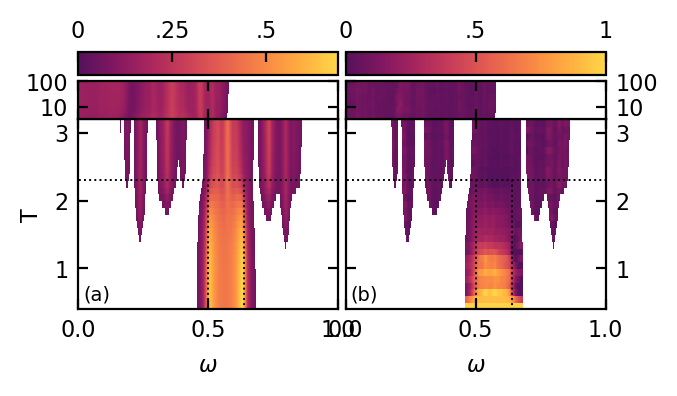

In [9]:
with open('/home/tch14/HPC_data/pickled_data/gap_opening_U=5.pickle', 'rb') as file:
    oU5 = pickle.load(file)
    
plot_gap_opening(oU5,  oU5log, xlim = (0, 1))

o.Ns = [ 60. 120. 270.]
N1 = 270.0, N2 = 60.0


/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


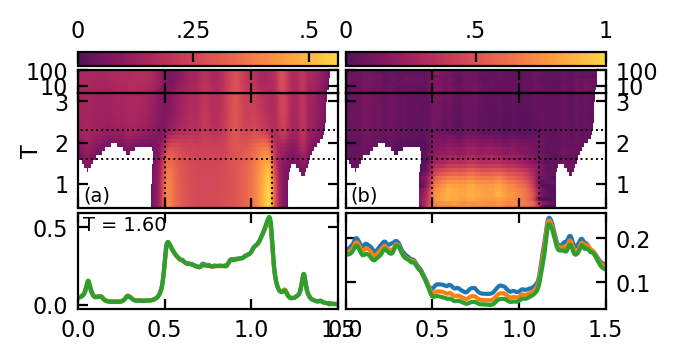

In [60]:
def plot_gap_opening_and_slice(o, olog = None, xlim = (-3.5/2, 3.5/2), T_i = 5):
    from FKMC.general import smooth
    import matplotlib.gridspec as gridspec

    f = plt.figure()
    gs0 = gridspec.GridSpec(3, 2, figure=f, wspace = 0.03,
                                            hspace = 0.05,
                                            height_ratios = (1,10,7),
                                            width_ratios = (1,1))

    lgs, rgs = [gs0[1, i].subgridspec(2,1, 
                                      height_ratios = (1,5),
                                      hspace = 0,
                                     ) for i in range(2)]
    #top
    caxes = [f.add_subplot(gs0[0,0]), f.add_subplot(gs0[0,1])]
    
    #middle, itself split into two
    axes = [f.add_subplot(lgs[1,0]), f.add_subplot(rgs[1,0])]
    logaxes = [f.add_subplot(lgs[0,0]), f.add_subplot(rgs[0,0])]
    
    #bottom
    slice_axes = [f.add_subplot(gs0[2,0]), f.add_subplot(gs0[2,1])]

    ax = axes[0]
    logax = logaxes[0]


    print(f'o.Ns = {o.Ns}')
    i1 = 2; i2 = 0
    N1 = o.Ns[i1]; N2 = o.Ns[i2]
    print(f'N1 = {N1}, N2 = {N2}')


    E_i = 2
    E_threshold = 0.07
    E = smooth(o.DOS[E_i], scale = 0.5, axis = -1)
    E = np.where(E > 0.06, E, np.NaN)
    I = np.where(E > 0.06, -o.m, np.NaN)

    for i, N in enumerate(o.Ns):
        slice_axes[0].plot(o.E_bins[1:]/o.parameters.U, o.DOS[i, T_i])
        slice_axes[1].plot(o.E_bins[1:]/o.parameters.U, o.IPR[i, T_i])
    
    if olog:
        olog.E = smooth(olog.DOS[E_i], scale = 0.5, axis = -1)
        olog.E = np.where(olog.E > 0.06, olog.E, np.NaN)
        olog.I = np.where(olog.E > 0.06, -olog.m, np.NaN)

    norm = mpl.colors.Normalize(vmin = 0)
    custom_cmap.set_bad(color='white')
    pcol = ax.pcolormesh(o.E_bins/o.parameters.U, o.Ts, E, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True)
    cbar = f.colorbar(pcol, cax = caxes[0], orientation="horizontal")

    if olog: pcol = logax.pcolormesh(o.E_bins/o.parameters.U, olog.Ts, olog.E, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True)

    ax.set(ylabel = 'T', ylim = (0.1, 4), xlim = (-4, 4))

    caxes[0].set_label(f'DOS (N = {o.Ns[E_i]})')

    cbar.set_ticks([0, .25, .5])
    cbar.set_ticklabels(['0', '.25', '.5'])

    #plot the E-T IPR diagram Diagram
    ax = axes[1]
    logax = logaxes[1]
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    pcol = ax.pcolormesh(o.E_bins/o.parameters.U, o.Ts, I, norm = norm, cmap= custom_cmap, linewidth=0, rasterized = True)
    cbar = f.colorbar(pcol, cax = caxes[1], orientation="horizontal")

    if olog: pcol = logax.pcolormesh(o.E_bins/o.parameters.U, olog.Ts, olog.I, norm = norm, cmap=custom_cmap, linewidth=0, rasterized = True)
    cbar.set_ticks([0, .5, 1])
    cbar.set_ticklabels(['0', '.5', '1'])

    for a,b,c in zip(axes, logaxes, slice_axes): 
        a.tick_params(direction = "in", labelbottom = False)
        b.tick_params(labelbottom = False)
        a.set(xlim = xlim)

        maxliny = 3.2

        a.set(ylim = (0.4,maxliny),
              yticks = [0,1,2,3],
        )
        b.set(yscale = 'log')
        b.set(
            ylim = (maxliny,100),
            yticks = [10,100],
            yticklabels = ['10','100'],
            xlim = xlim,
        )
        
        c.set(xlim = xlim)


    axes[1].tick_params(labelleft = False)

    for a in [axes[-1], logaxes[-1], slice_axes[-1]]:
        a.tick_params(labelleft = False, labelright = True)
        

    for cax in caxes: cax.tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)

    for label, ax, color in zip(["(a)","(b)"], axes, ['k', 'k']):
        ax.text(0.02, 0.03, label, transform=ax.transAxes, va='bottom', ha = 'left',
                fontsize=7, fontweight='normal', color = color)
    
    ax=slice_axes[0]
    ax.text(0.02, 0.97, f'T = {o.Ts[T_i]:.2f}', transform=ax.transAxes, va='top', ha = 'left',
            fontsize=7, fontweight='normal', color = color)
    

    Tc = 2.3
    #pm 1/2 np.sqrt(4*U**2 + 8t**2(1 + cos(ka)))
    bounds = np.array([-1,-1,+1,+1]) * 0.5 * np.sqrt(o.parameters.U**2 + 8*np.array([0,2,0,2])) / o.parameters.U
    #bounds = [-2.3/2, -0.9/2, 0.9/2, 2.3/2]
    
    for ax in axes[:2]:
        ax.hlines(y = (Tc, o.Ts[T_i]), xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'k')
        ax.vlines(x = bounds, ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'k')


    f.subplots_adjust()
    f.set_size_inches(columnwidth,columnwidth/2)
 
with open(Path('~/HPC_data/pickled_data/gap_opening.pickle').expanduser(), 'rb') as file:
    o = pickle.load(file)
    
with open(Path('~/HPC_data/pickled_data/gap_opening_high_temp_log.pickle').expanduser(), 'rb') as file:
    olog = pickle.load(file)

plot_gap_opening_and_slice(o, olog, xlim = (0,1.5), T_i = 15)

o.Ns = [ 60. 120. 270.]
N1 = 270.0, N2 = 60.0


/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


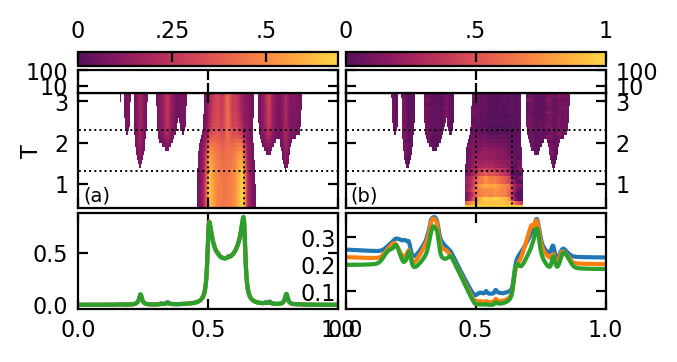

In [54]:
plot_gap_opening_and_slice(oU5, xlim = (0,1), T_i = 12)

/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


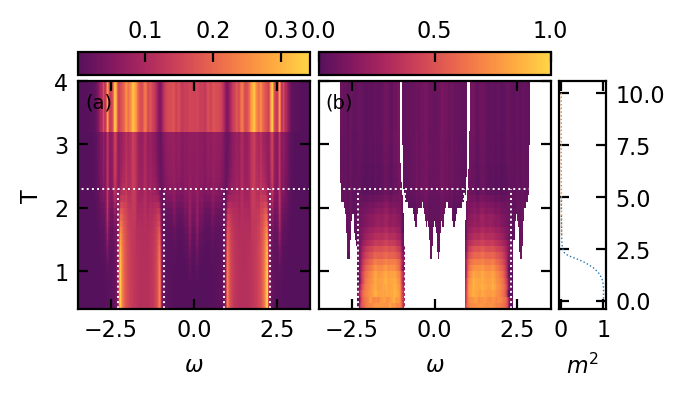

In [15]:
import pickle

with open('/home/tch14/HPC_data/pickled_data/gap_opening.pickle', 'rb') as file:
    o1 = pickle.load(file)
    
#with open('/home/tch14/HPC_data/pickled_data/gap_opening_low_temp.pickle', 'rb') as file:
#    o2 = pickle.load(file)

with open('/home/tch14/HPC_data/pickled_data/gap_opening_high_temp_log.pickle', 'rb') as file:
    olog = pickle.load(file)
    
os = [
    o1,
]

from FKMC.general import smooth

columnwidth = 246/72.27
width = columnwidth
height =  columnwidth / 2
dpi = 150

f, (caxes, axes) = plt.subplots(2,3, gridspec_kw = dict(wspace = 0.05, hspace = 0.05, height_ratios = (1,10), width_ratios = (5,5,1)))
caxes[-1].set(visible = False)    

#plot the E-T DOS Diagram

ax = axes[0]
#norm = mpl.colors.Normalize(vmin=0, vmax=1)

for o in os:
    axes[2].plot(o.Mf_moments.mean(axis = 1)[-1, :, 2], o.Ts, linewidth = 0.5, linestyle = 'dotted')

axes[2].set(xlabel = '$m^2$')


E_i = 2
for o in os:
    pcol = ax.pcolormesh(o.E_bins, o.Ts, o.DOS[-1], cmap=custom_cmap, linewidth=0, rasterized = True)

cbar = f.colorbar(pcol, cax = caxes[0], orientation="horizontal")
ax.set(ylabel = 'T', xlabel = '$\omega$', ylim = (0.1, 4), xlim = (-4, 4))
caxes[0].set_label(f'DOS (N = {o.Ns[E_i]})')

#plot the E-T IPR diagram Diagram
ax = axes[1]
norm = mpl.colors.Normalize(vmin=0, vmax=1)

for o in os:
    pcol = ax.pcolormesh(o.E_bins, o.Ts, np.where(o.DOS[-1] > 0.07, -o.m, np.NaN), norm = norm, cmap= custom_cmap, linewidth=0, rasterized = True)

f.colorbar(pcol, cax = caxes[1], orientation="horizontal")
ax.set(xlabel = '$\omega$', )

for a in axes[:2]: 
    a.tick_params(direction = "in")
    a.set(ylim = (0,4), xlim = (-3.5,3.5))
   
axes[1].tick_params(labelleft = False)
axes[-1].tick_params(labelleft = False, labelright = True)
    
for cax in caxes: cax.tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)
  
for label, ax in zip(["(a)","(b)"], axes):
    ax.text(0.03, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
Tc = 2.3
for ax in axes[:2]:
    ax.hlines(y = Tc, xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'white')
    ax.vlines(x = [-2.3, -0.9, 0.9, 2.3], ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'white')
    ax.set(ylim = (0.4,4))
    
f.subplots_adjust()
f.set_size_inches(width,height)

[1.         1.         1.         1.         0.99972369 0.99929988
 0.99715575 0.99269974 0.98442529 0.97218289 0.95453377 0.92810047
 0.90010319 0.855957   0.808848   0.75226481 0.67255045 0.59612157
 0.49972361 0.38406572 0.25349451 0.14912438 0.08241651 0.0548539
 0.04125824 0.03151733 0.02508207 0.02178143 0.01920998 0.01654869
 0.01554537 0.01427106 0.01282859 0.01217749 0.0115577  0.01096962
 0.01043891 0.00998221 0.00958951 0.00926538 0.00901141 0.00866966
 0.00850306 0.00820411 0.00811063 0.00761507 0.00747377 0.00749694
 0.00737271 0.00715538]
o1.Ns = [ 60. 120. 270.]
o2.Ns = [ 60. 120. 270.]
o.Ts = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6
 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5. ]
o2.Ts = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


/rds/general/user/tch14/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


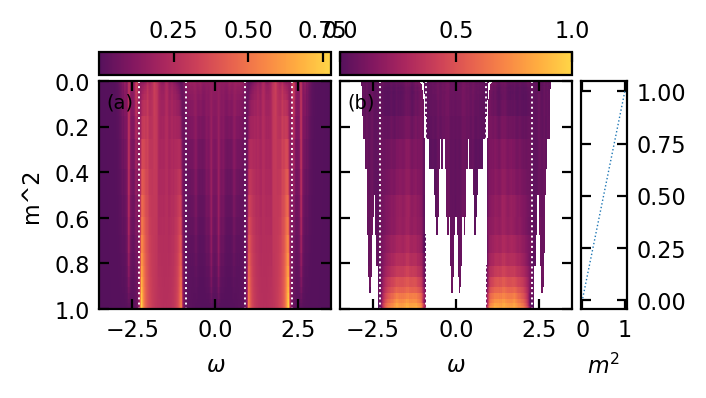

In [11]:
import pickle

with open('/home/tch14/HPC_data/pickled_data/gap_opening.pickle', 'rb') as file:
    o1 = pickle.load(file)
    
with open('/home/tch14/HPC_data/pickled_data/gap_opening_low_temp.pickle', 'rb') as file:
    o2 = pickle.load(file)
    
os = [
    o1,
    #o2,
]

from FKMC.general import smooth

columnwidth = 246/72.27
width = columnwidth
height =  columnwidth / 2
dpi = 150

f, (caxes, axes) = plt.subplots(2,3, gridspec_kw = dict(wspace = 0.05, hspace = 0.05, height_ratios = (1,10), width_ratios = (5,5,1)))
caxes[-1].set(visible = False)    

#plot the E-T DOS Diagram

ax = axes[0]
#norm = mpl.colors.Normalize(vmin=0, vmax=1)

for o in os:
    o.M2 = np.nanmean(o.Mf_moments, axis = 1)[-1, :, 2]
    axes[2].plot(o.M2, o.M2, linewidth = 0.5, linestyle = 'dotted')
    print(o.M2)
    
    
axes[2].set(xlabel = '$m^2$')
    
print(f'o1.Ns = {o1.Ns}')
print(f'o2.Ns = {o2.Ns}')
print(f'o.Ts = {o1.Ts}')
print(f'o2.Ts = {o2.Ts}')

E_i = 2
for o in os:
    pcol = ax.pcolormesh(o.E_bins, o.M2, o.DOS[-1], cmap=custom_cmap, linewidth=0, rasterized = True)

cbar = f.colorbar(pcol, cax = caxes[0], orientation="horizontal")
ax.set(ylabel = 'm^2', xlabel = '$\omega$', ylim = (0.1, 4), xlim = (-4, 4))
caxes[0].set_label(f'DOS (N = {o.Ns[E_i]})')

#plot the E-T IPR diagram Diagram
ax = axes[1]
norm = mpl.colors.Normalize(vmin=0, vmax=1)

for o in os:
    pcol = ax.pcolormesh(o.E_bins, o.M2, np.where(o.DOS[-1] > 0.07, -o.m, np.NaN), norm = norm, cmap= custom_cmap, linewidth=0, rasterized = True)

f.colorbar(pcol, cax = caxes[1], orientation="horizontal")
ax.set(xlabel = '$\omega$', )

for a in axes[:2]: 
    a.tick_params(direction = "in")
    a.set(ylim = (0,4), xlim = (-3.5,3.5))
   
axes[1].tick_params(labelleft = False)
axes[-1].tick_params(labelleft = False, labelright = True)
    
for cax in caxes: cax.tick_params(bottom = False, top = True, labelbottom = False, labeltop = True)
  
for label, ax in zip(["(a)","(b)"], axes):
    ax.text(0.03, 0.95, label, transform=ax.transAxes,
            fontsize=7, fontweight='normal', va='top', color = 'black')
    
Tc = 2.3
for ax in axes[:2]:
    ax.hlines(y = Tc, xmin = -4, xmax = 4, linewidth = 0.7, linestyle = 'dotted', color = 'white')
    ax.vlines(x = [-2.3, -0.9, 0.9, 2.3], ymin = 0, ymax = Tc, linewidth = 0.7, linestyle = 'dotted', color = 'white')
    ax.set(ylim = (1,0))
    
f.subplots_adjust()
f.set_size_inches(width,height)

In [12]:
o.hints.IPR, o.IPR.shape

(('Ns', 'Rs', 'Ts', 'energy index'), (3, 50, 2000))

In [13]:
np.random.randint(1,3)

1